# Lib Import

In [1]:
# --- 安装必要的库 ---
# 请确保您已按照上述说明安装了 libvips 系统库
# pip install pyvips opencv-python scikit-image tqdm

import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.color import rgb2hed
from skimage.filters import threshold_otsu
from IPython.display import display, Image as IPImage

# 导入 pyvips 库
try:
    import pyvips
except ImportError:
    print("错误: pyvips 库未找到。请按照单元格上方的说明进行安装。")
    # 在 Notebook 中，我们可以用 raise 来停止执行
    raise

# 使用 tqdm.notebook 可以在 Notebook 中显示更好看的进度条
from tqdm.auto import tqdm

os.chdir("/home1/jijh/diffusion_project/ADiffusion")
os.getcwd()

import importlib
from src.pipeline.hest_loading import HESTDataset, HESTSample

# --- 全局设置 ---
DATA_DIR = "/cwStorage/nodecw_group/jijh/hest_1k" 

# 设置 Matplotlib 和 Seaborn 的样式
sns.set_theme(style="whitegrid", context="notebook")
plt.rcParams['figure.figsize'] = (10, 6)

print("库导入成功，pyvips 已准备就绪。")

库导入成功，pyvips 已准备就绪。


# Functions Definitions

In [2]:
def calculate_wsi_qc_metrics_high_res(sample: HESTSample, target_size: int = 2048) -> dict:
    """
    使用 pyvips 直接从 WSI 文件计算高质量的 QC 指标。

    参数:
      sample (HESTSample): 要分析的 HEST 样本对象。
      target_size (int): 希望将 WSI 缩放到的目标尺寸（例如 2048x2048）。
                         这提供了比低级缩略图高得多的分辨率。

    返回:
      dict: 包含所有计算出的 QC 指标的字典。
    """
    # 初始化指标字典
    qc_results = {
        'sample_id': sample.sample_id,
        'file_size_mb': np.nan, 'brightness': np.nan, 'contrast': np.nan,
        'blurriness_laplacian': np.nan, 'tissue_area_fraction': np.nan,
        'hematoxylin_intensity': np.nan, 'eosin_intensity': np.nan
    }
    
    # 检查 WSI 文件路径是否存在
    if not sample.wsi_path or not os.path.exists(sample.wsi_path):
        return qc_results

    try:
        # --- 1. 使用 pyvips 高效加载和缩放 WSI ---
        # pyvips.Image.new_from_file 会智能地处理 WSI，不会立即加载所有数据
        image = pyvips.Image.new_from_file(sample.wsi_path)
        
        # image.thumbnail_image 是一个非常高效的操作，可以从 WSI 金字塔中选择
        # 合适的层级并缩放到目标尺寸，内存占用极小。
        high_res_thumb = image.thumbnail_image(target_size, height=target_size, crop='centre')
        
        # 将 pyvips 图像转换为 NumPy 数组以便用 OpenCV/Scikit-Image 处理
        high_res_thumb_np = np.ndarray(
            buffer=high_res_thumb.write_to_memory(),
            dtype=np.uint8,
            shape=[high_res_thumb.height, high_res_thumb.width, high_res_thumb.bands]
        )
        
        # 如果图像有 alpha 通道，移除它
        if high_res_thumb_np.shape[2] == 4:
            high_res_thumb_np = cv2.cvtColor(high_res_thumb_np, cv2.COLOR_BGRA2RGB)
        else:
             high_res_thumb_np = cv2.cvtColor(high_res_thumb_np, cv2.COLOR_BGR2RGB)


        # --- 2. 基于高分辨率图像计算 QC 指标 (逻辑同前，但输入更精确) ---
        qc_results['file_size_mb'] = os.path.getsize(sample.wsi_path) / (1024 * 1024)
        
        gray_thumb = cv2.cvtColor(high_res_thumb_np, cv2.COLOR_RGB2GRAY)

        # 通用指标
        qc_results['brightness'] = np.mean(gray_thumb)
        qc_results['contrast'] = np.std(gray_thumb)
        qc_results['blurriness_laplacian'] = cv2.Laplacian(gray_thumb, cv2.CV_64F).var()

        # 病理学专用指标
        thresh_val = threshold_otsu(gray_thumb)
        tissue_mask = (gray_thumb < thresh_val).astype(np.uint8)
        
        tissue_area = np.sum(tissue_mask)
        if tissue_mask.size > 0:
            qc_results['tissue_area_fraction'] = tissue_area / tissue_mask.size

        if tissue_area > 0:
            hed_thumb = rgb2hed(high_res_thumb_np)
            hematoxylin_channel = hed_thumb[:, :, 0]
            eosin_channel = hed_thumb[:, :, 1]
            qc_results['hematoxylin_intensity'] = np.mean(hematoxylin_channel[tissue_mask == 1])
            qc_results['eosin_intensity'] = np.mean(eosin_channel[tissue_mask == 1])

        return qc_results

    except pyvips.Error as e:
        print(f"PyVIPS 错误 (样本 {sample.sample_id}): {e} - 可能文件损坏或格式不受支持。")
        return qc_results
    except Exception as e:
        print(f"处理样本 {sample.sample_id} 时发生未知错误: {e}")
        return qc_results

# Main Execution

In [3]:
# 1. 初始化数据集
print(f"正在从 '{DATA_DIR}' 加载数据集...")
dataset = HESTDataset(data_dir=DATA_DIR)
print("数据集元数据加载成功。")

# 2. 选择样本进行分析
print("\n正在查询所有样本以进行高分辨率 WSI QC 分析...")
samples_to_analyze = dataset.get_samples()
print(f"总共找到 {len(samples_to_analyze)} 个样本。")

正在从 '/cwStorage/nodecw_group/jijh/hest_1k' 加载数据集...
数据集元数据加载成功。

正在查询所有样本以进行高分辨率 WSI QC 分析...
总共找到 1229 个样本。


In [ ]:


# --- 调试和批处理设置 ---
BATCH_SIZE = 50  # 将任务分成每批 50 个文件，可以根据需要调整
TARGET_RESOLUTION = 2048
all_qc_data = [] # 用于存储所有批次的结果
output_csv_path = "./wsi_qc_results.csv" # 中间结果保存路径

print(f"\n将以每批 {BATCH_SIZE} 个样本的规模进行处理...")

# 3. 分批循环计算 QC 指标
num_batches = (len(samples_to_analyze) + BATCH_SIZE - 1) // BATCH_SIZE

for i in range(num_batches):
    start_index = i * BATCH_SIZE
    end_index = start_index + BATCH_SIZE
    current_batch = samples_to_analyze[start_index:end_index]
    
    print(f"\n--- 正在处理批次 {i+1}/{num_batches} (样本 {start_index+1} 到 {end_index}) ---")
    
    batch_qc_data = []
    # 使用 tqdm 跟踪当前批次的进度
    for sample in tqdm(current_batch, desc=f"批次 {i+1}"):
        # ======================= 关键修改 =======================
        # 在处理前打印文件名，如果在这里崩溃，最后一个打印的文件就是罪魁祸首
        print(f"正在处理: {sample.sample_id} ({sample.wsi_path})")
        # ========================================================
        
        qc_metrics = calculate_wsi_qc_metrics_high_res(sample, target_size=TARGET_RESOLUTION)
        batch_qc_data.append(qc_metrics)
        
    # 将当前批次的结果添加到总列表中
    all_qc_data.extend(batch_qc_data)
    
    # 将目前为止的所有结果保存到 CSV 文件，以防崩溃后数据丢失
    temp_df = pd.DataFrame(all_qc_data)
    temp_df.to_csv(output_csv_path, index=False)
    print(f"批次 {i+1} 完成。至今 {len(all_qc_data)} 个结果已保存到 '{output_csv_path}'")


# 4. 创建最终的 DataFrame 并显示摘要
qc_df = pd.DataFrame(all_qc_data).dropna(how='all', subset=['brightness'])

print("\n\n所有批次处理完成！")
print("--- 最终 QC 指标统计摘要 ---")
display(qc_df.describe().T)

: 

In [ ]:
output_csv_path = "./wsi_qc_results.csv" # 中间结果保存路径
qc_df = pd.read_csv(output_csv_path)
display(qc_df.describe().T)

,count,mean,std,min,25%,50%,75%,max
file_size_mb,1229.0,751.984562,1305.159960,1.347945e+01,96.880244,205.643323,663.253484,14364.410563
brightness,1229.0,203.917588,29.446194,1.009667e+02,189.265842,209.454827,227.008577,247.998725
contrast,1229.0,38.747267,13.812881,8.961911e+00,30.425507,37.570888,44.887528,96.577770
blurriness_laplacian,1229.0,1159.716416,1107.496564,2.828898e+01,427.661813,819.092488,1531.259557,8487.154366
tissue_area_fraction,1229.0,0.282465,0.157592,1.008725e-02,0.158266,0.264057,0.374992,0.972088
hematoxylin_intensity,1229.0,0.037760,0.080522,3.197413e-05,0.013640,0.026976,0.043592,1.187090
eosin_intensity,1229.0,0.018871,0.022431,7.226662e-09,0.006436,0.012259,0.022884,0.164104


正在生成 Pair-Plot...


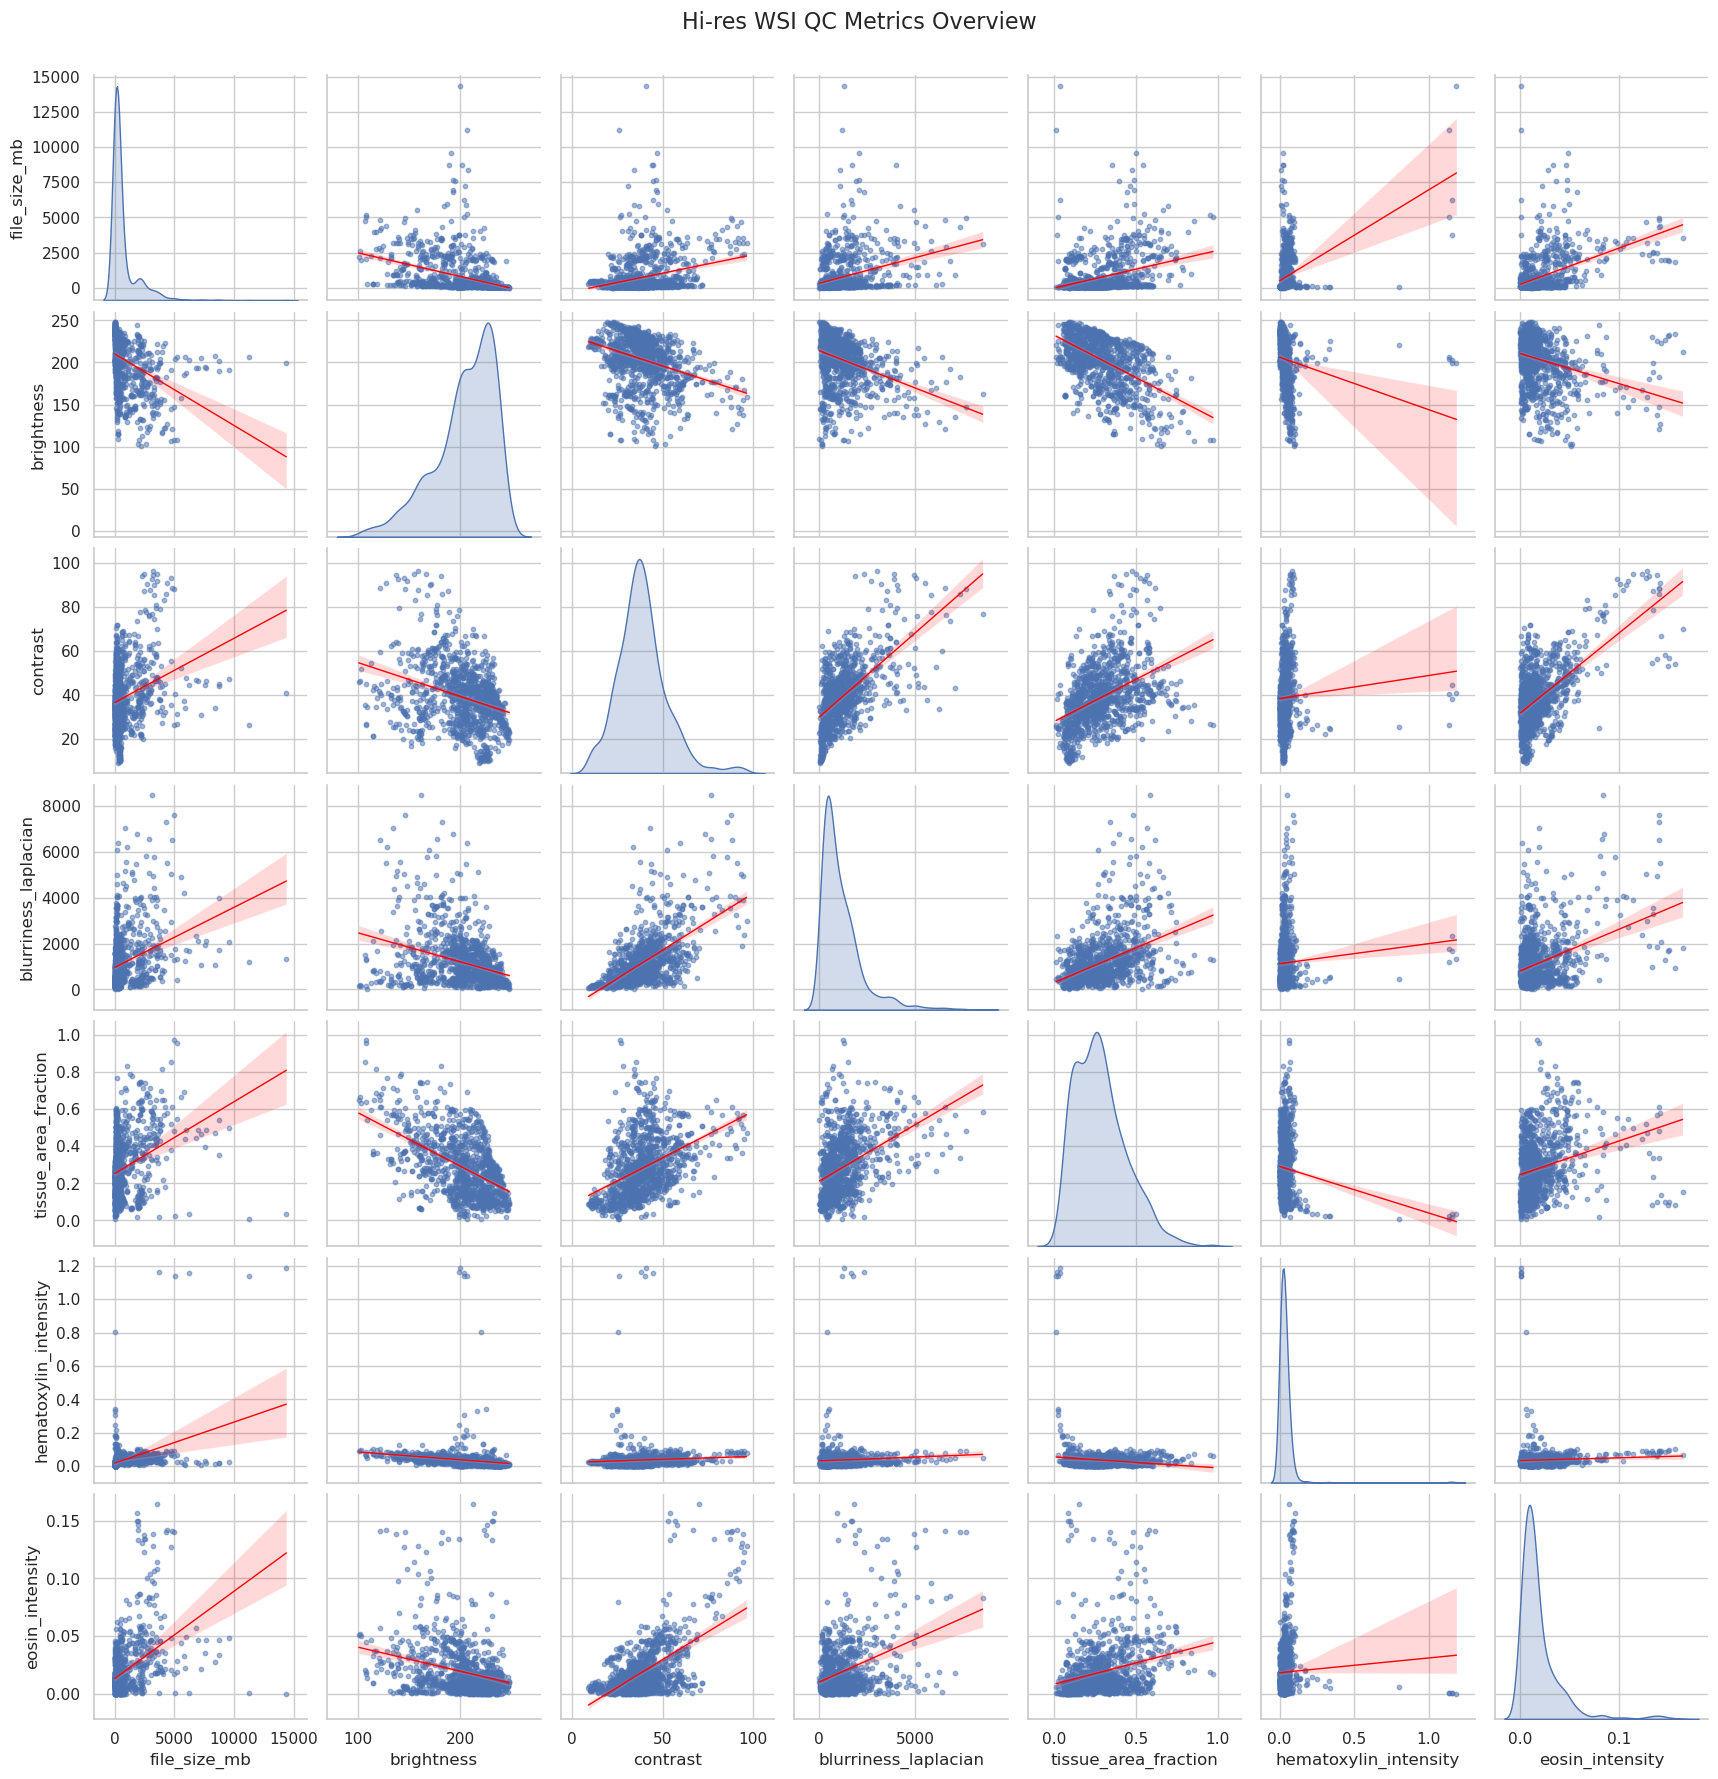

In [11]:
if not qc_df.empty:
    print("正在生成 Pair-Plot...")
    plot_df = qc_df.drop('sample_id', axis=1)
    pair_plot = sns.pairplot(
        plot_df, 
        kind='reg',
        plot_kws={'line_kws':{'color':'red', 'linewidth':1}, 'scatter_kws': {'alpha': 0.5, 's': 10}},
        diag_kind='kde'
    )
    pair_plot.fig.suptitle('Hi-res WSI QC Metrics Overview', y=1.02, fontsize=16)
    plt.show()
else:
    print("QC DataFrame 为空，无法绘图。")

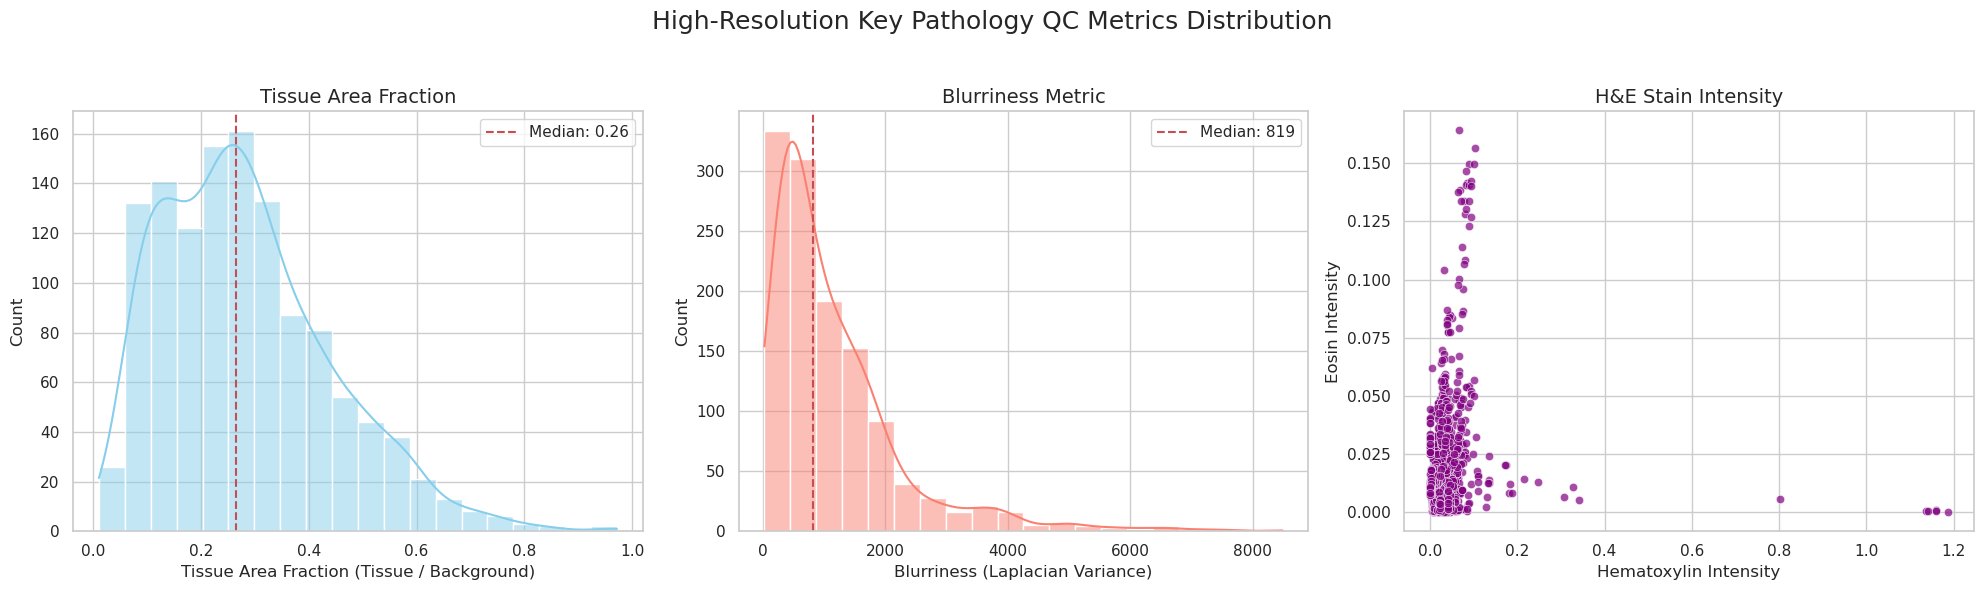

In [12]:
if not qc_df.empty:
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    fig.suptitle('High-Resolution Key Pathology QC Metrics Distribution', fontsize=18)

    # Tissue Area Fraction
    sns.histplot(data=qc_df, x='tissue_area_fraction', kde=True, ax=axes[0], bins=20, color='skyblue')
    axes[0].set_title('Tissue Area Fraction', fontsize=14)
    axes[0].set_xlabel('Tissue Area Fraction (Tissue / Background)')
    axes[0].axvline(qc_df['tissue_area_fraction'].median(), color='r', linestyle='--', label=f"Median: {qc_df['tissue_area_fraction'].median():.2f}")
    axes[0].legend()

    # Blurriness
    sns.histplot(data=qc_df, x='blurriness_laplacian', kde=True, ax=axes[1], bins=20, color='salmon')
    axes[1].set_title('Blurriness Metric', fontsize=14)
    axes[1].set_xlabel('Blurriness (Laplacian Variance)')
    axes[1].axvline(qc_df['blurriness_laplacian'].median(), color='r', linestyle='--', label=f"Median: {qc_df['blurriness_laplacian'].median():.0f}")
    axes[1].legend()

    # H&E Stain Intensity
    sns.scatterplot(data=qc_df, x='hematoxylin_intensity', y='eosin_intensity', ax=axes[2], alpha=0.7, color='purple')
    axes[2].set_title('H&E Stain Intensity', fontsize=14)
    axes[2].set_xlabel('Hematoxylin Intensity')
    axes[2].set_ylabel('Eosin Intensity')
    axes[2].grid(True)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()
else:
    print("QC DataFrame is empty, cannot generate plots.")

HESTSample(sample_id=TENX159)
  ST file: /cwStorage/nodecw_group/jijh/hest_1k/st/TENX159.h5ad
  WSI file: /cwStorage/nodecw_group/jijh/hest_1k/wsis/TENX159.tif
  transcripts: /cwStorage/nodecw_group/jijh/hest_1k/transcripts/TENX159_transcripts.parquet
  spatial plot: /cwStorage/nodecw_group/jijh/hest_1k/spatial_plots/TENX159_spatial_plots.png



--- 识别到潜在的低质量样本 (ID: NCBI308) ---
--- 正在检查潜在的低质量样本 (基于最低模糊度) ---


,sample_id,file_size_mb,brightness,contrast,blurriness_laplacian,tissue_area_fraction,hematoxylin_intensity,eosin_intensity
917,NCBI308,18.415914,247.998725,22.538693,28.288981,0.088465,0.012124,0.01023



正在显示样本 'NCBI308' 的 2048px 图像以供目视检查:


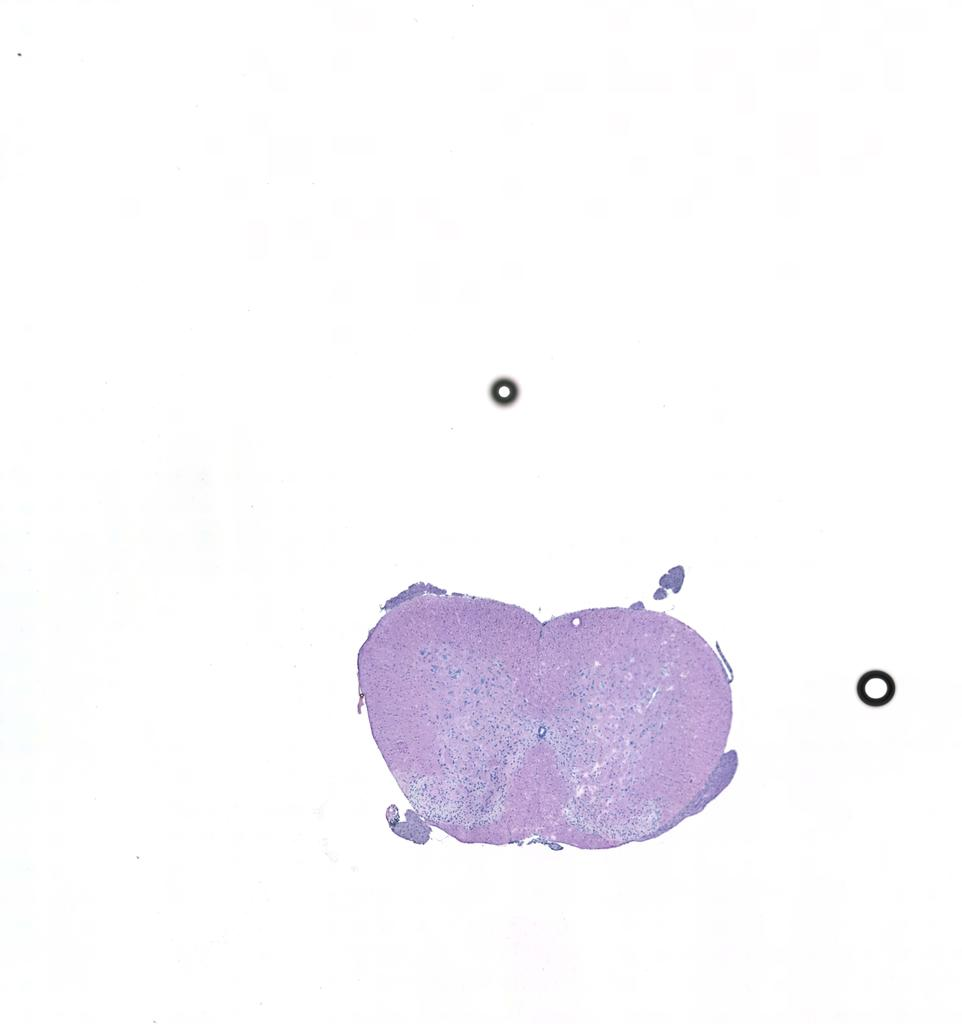

In [20]:
if not qc_df.empty:
    # 1. 识别潜在的低质量样本 (例如，模糊度最低的样本)
    outlier_sample_info = qc_df.nsmallest(1, 'blurriness_laplacian')
    outlier_id = outlier_sample_info['sample_id'].iloc[0]
    # 获取路径
    for sample in samples_to_analyze:
        if sample.sample_id == outlier_id:
            outlier_path = sample.wsi_path
            break
    else:
        print("QC DataFrame 为空，无法识别低质量样本。")
    # 2. 显示潜在低质量样本的详细信息
    print(f"\n\n--- 识别到潜在的低质量样本 (ID: {outlier_id}) ---")

    print(f"--- 正在检查潜在的低质量样本 (基于最低模糊度) ---")
    display(outlier_sample_info)

    # 2. 直接使用 pyvips 加载并显示其高分辨率缩略图
    print(f"\n正在显示样本 '{outlier_id}' 的 {TARGET_RESOLUTION}px 图像以供目视检查:")
    
    try:
        image = pyvips.Image.new_from_file(outlier_path)
        # 我们将图像保存到内存中的一个临时 buffer，然后用 IPython 显示它
        image_buffer = image.thumbnail_image(1024).write_to_buffer('.jpg') # 缩放到 1024px 显示
        display(IPImage(data=image_buffer))
    except Exception as e:
        print(f"无法显示图像: {e}")

In [22]:
# 读取NCBI308的anndata

for sample in samples_to_analyze:
    if sample.sample_id == outlier_id:
        test_sample = sample
        break

test_anndata = test_sample.load_st_data()


/public/home/jijh/micromamba/envs/imgprocess/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [30]:
# 将lazy读取的anndata实际上读进内存
test_anndata = test_anndata.to_memory()

/public/home/jijh/micromamba/envs/imgprocess/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [31]:
test_anndata

AnnData object with n_obs × n_vars = 89 × 12460
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mito'
    uns: 'spatial'
    obsm: 'spatial'

In [36]:
test_anndata.obs[['x', 'y']] = test_anndata.obsm['spatial']

<Axes: xlabel='x', ylabel='y'>

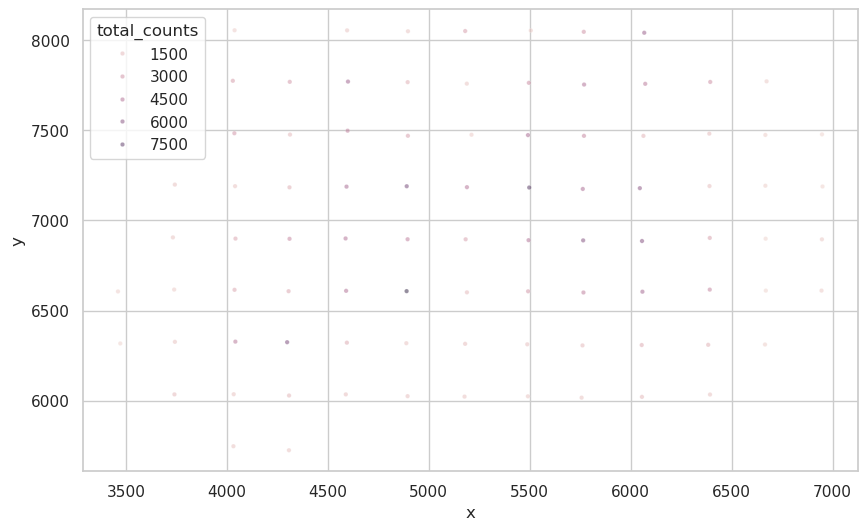

In [37]:
obs_df = test_anndata.obs.copy()
sns.scatterplot(data=obs_df, x='x', y='y', hue='total_counts', alpha=0.5, s=10)

# 正式QC

In [1]:
# --- 安装必要的库 ---
# 请确保您已按照上述说明安装了 libvips 系统库
# pip install pyvips opencv-python scikit-image tqdm

import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.color import rgb2hed
from skimage.filters import threshold_otsu
from IPython.display import display, Image as IPImage

# 导入 pyvips 库
try:
    import pyvips
except ImportError:
    print("错误: pyvips 库未找到。请按照单元格上方的说明进行安装。")
    # 在 Notebook 中，我们可以用 raise 来停止执行
    raise

# 使用 tqdm.notebook 可以在 Notebook 中显示更好看的进度条
from tqdm.auto import tqdm

os.chdir("/home1/jijh/diffusion_project/ADiffusion")
os.getcwd()

import importlib
from src.pipeline.hest_loading import HESTDataset, HESTSample

# --- 全局设置 ---
DATA_DIR = "/cwStorage/nodecw_group/jijh/hest_1k" 

# 设置 Matplotlib 和 Seaborn 的样式
sns.set_theme(style="whitegrid", context="notebook")
plt.rcParams['figure.figsize'] = (10, 6)

print("库导入成功，pyvips 已准备就绪。")
# 1. 初始化数据集
print(f"正在从 '{DATA_DIR}' 加载数据集...")
dataset = HESTDataset(data_dir=DATA_DIR)
print("数据集元数据加载成功。")

# 2. 选择样本进行分析
print("\n正在查询所有样本以进行高分辨率 WSI QC 分析...")
samples_to_analyze = dataset.get_samples()
print(f"总共找到 {len(samples_to_analyze)} 个样本。")

库导入成功，pyvips 已准备就绪。
正在从 '/cwStorage/nodecw_group/jijh/hest_1k' 加载数据集...
数据集元数据加载成功。

正在查询所有样本以进行高分辨率 WSI QC 分析...
总共找到 1229 个样本。


In [2]:
output_csv_path = "./wsi_qc_results.csv" # 中间结果保存路径
qc_df = pd.read_csv(output_csv_path)
display(qc_df.describe().T)

,count,mean,std,min,25%,50%,75%,max
file_size_mb,1229.0,751.984562,1305.159960,1.347945e+01,96.880244,205.643323,663.253484,14364.410563
brightness,1229.0,203.917588,29.446194,1.009667e+02,189.265842,209.454827,227.008577,247.998725
contrast,1229.0,38.747267,13.812881,8.961911e+00,30.425507,37.570888,44.887528,96.577770
blurriness_laplacian,1229.0,1159.716416,1107.496564,2.828898e+01,427.661813,819.092488,1531.259557,8487.154366
tissue_area_fraction,1229.0,0.282465,0.157592,1.008725e-02,0.158266,0.264057,0.374992,0.972088
hematoxylin_intensity,1229.0,0.037760,0.080522,3.197413e-05,0.013640,0.026976,0.043592,1.187090
eosin_intensity,1229.0,0.018871,0.022431,7.226662e-09,0.006436,0.012259,0.022884,0.164104


In [3]:
# Assuming your QC data is in a pandas DataFrame 'qc_df'

# Define quality thresholds based on the analysis
TISSUE_THRESHOLD = 0.05
BLURRINESS_THRESHOLD = 250
STAIN_OUTLIER_THRESHOLD = 0.01 # For Eosin intensity

# Create boolean masks for high-quality samples
is_good_tissue = qc_df['tissue_area_fraction'] >= TISSUE_THRESHOLD
is_in_focus = qc_df['blurriness_laplacian'] >= BLURRINESS_THRESHOLD
is_good_stain = qc_df['eosin_intensity'] >= STAIN_OUTLIER_THRESHOLD

# Combine masks to get the final high-quality set
high_quality_samples_df = qc_df[is_good_tissue & is_in_focus & is_good_stain]
high_quality_ids = high_quality_samples_df['sample_id'].tolist()

print(f"Original samples: {len(qc_df)}")
print(f"High-quality samples after filtering: {len(high_quality_samples_df)}")

Original samples: 1229
High-quality samples after filtering: 685


In [4]:
# Get IDs of samples to review
blurry_ids = qc_df[~is_in_focus]['sample_id'].tolist()
stain_problem_ids = qc_df[~is_good_stain]['sample_id'].tolist()

print("Potentially blurry samples to review:", blurry_ids[:5])
print("Stain outlier samples to review:", stain_problem_ids[:5])

# Use a WSI viewer like QuPath or your Python tools to inspect these files.

Potentially blurry samples to review: ['TENX68', 'TENX16', 'MEND78', 'MEND77', 'MEND76']
Stain outlier samples to review: ['ZEN80', 'ZEN79', 'ZEN78', 'MISC133', 'MISC131']


In [5]:
# --- 1. Setup and Strategy Definition ---

# How many examples from each category of "low quality" do we want to see?
N_SAMPLES_PER_CATEGORY = 4 

# Make sure the main qc_df DataFrame is available and not empty
if 'qc_df' not in locals() or qc_df.empty:
    print("Error: 'qc_df' DataFrame not found or is empty.")
    print("Please run the QC calculation cells first.")
else:
    # This dictionary will store the unique sample IDs to visualize and the reason why
    # Using a dictionary automatically handles duplicates if a sample falls into multiple categories
    samples_to_visualize = {}

    print(f"Identifying the top {N_SAMPLES_PER_CATEGORY} worst samples from each quality category...")

    # --- 2. Intelligent Sampling from Different Failure Modes ---

    # Category 1: Most Blurry Samples (lowest Laplacian score)
    blurry_samples = qc_df.nsmallest(N_SAMPLES_PER_CATEGORY, 'blurriness_laplacian')
    for _, row in blurry_samples.iterrows():
        reason = f"Blurry (Score: {row['blurriness_laplacian']:.0f})"
        samples_to_visualize[row['sample_id']] = reason

    # Category 2: Lowest Tissue Area
    low_tissue_samples = qc_df.nsmallest(N_SAMPLES_PER_CATEGORY, 'tissue_area_fraction')
    for _, row in low_tissue_samples.iterrows():
        reason = f"Low Tissue (Frac: {row['tissue_area_fraction']:.2f})"
        # If the sample is already in our list, append the new reason
        if row['sample_id'] in samples_to_visualize:
            samples_to_visualize[row['sample_id']] += f"\n& {reason}"
        else:
            samples_to_visualize[row['sample_id']] = reason

    # Category 3: Stain Outliers (likely "Hematoxylin-only")
    stain_outliers = qc_df.nsmallest(N_SAMPLES_PER_CATEGORY, 'eosin_intensity')
    for _, row in stain_outliers.iterrows():
        reason = f"H-Stain Outlier (Eosin: {row['eosin_intensity']:.3f})"
        if row['sample_id'] in samples_to_visualize:
            samples_to_visualize[row['sample_id']] += f"\n& {reason}"
        else:
            samples_to_visualize[row['sample_id']] = reason
            
    print(f"\nIdentified {len(samples_to_visualize)} unique low-quality samples to visualize.")
    # Display the list of samples and their issues
    for sample_id, reason in samples_to_visualize.items():
        print(f"  - ID: {sample_id}, Reason(s): {reason.replace(chr(10), ' ')}")

Identifying the top 4 worst samples from each quality category...

Identified 12 unique low-quality samples to visualize.
  - ID: NCBI308, Reason(s): Blurry (Score: 28)
  - ID: TENX16, Reason(s): Blurry (Score: 34)
  - ID: NCBI471, Reason(s): Blurry (Score: 41)
  - ID: NCBI474, Reason(s): Blurry (Score: 49)
  - ID: TENX99, Reason(s): Low Tissue (Frac: 0.01)
  - ID: NCBI824, Reason(s): Low Tissue (Frac: 0.01)
  - ID: TENX96, Reason(s): Low Tissue (Frac: 0.02)
  - ID: MISC52, Reason(s): Low Tissue (Frac: 0.02)
  - ID: MEND7, Reason(s): H-Stain Outlier (Eosin: 0.000)
  - ID: MEND2, Reason(s): H-Stain Outlier (Eosin: 0.000)
  - ID: MEND5, Reason(s): H-Stain Outlier (Eosin: 0.000)
  - ID: MEND1, Reason(s): H-Stain Outlier (Eosin: 0.000)


In [6]:

path_dict = {s.sample_id: s.wsi_path for s in samples_to_analyze}
# 确保 samples_to_visualize 字典存在
if 'samples_to_visualize' in locals():
    # 将字典的键（sample_id）转换为列表
    sample_ids_in_order = list(samples_to_visualize.keys())
    
    # 获取第5个样本的ID (Python索引从0开始，所以是第4个元素)
    if len(sample_ids_in_order) > 4:
        problem_sample_id = sample_ids_in_order[4]
        
        # 从 path_dict 中获取它的路径
        problem_path = path_dict.get(problem_sample_id)
        
        print(f"--- 问题样本已定位 ---")
        print(f"ID: {problem_sample_id}")
        print(f"Path: {problem_path}")
    else:
        print("样本列表不足5个。")
else:
    print("samples_to_visualize 字典未找到。")

--- 问题样本已定位 ---
ID: TENX99
Path: /cwStorage/nodecw_group/jijh/hest_1k/wsis/TENX99.tif


Original image size: 51351 x 107121
Thumbnail size: 256 x 256


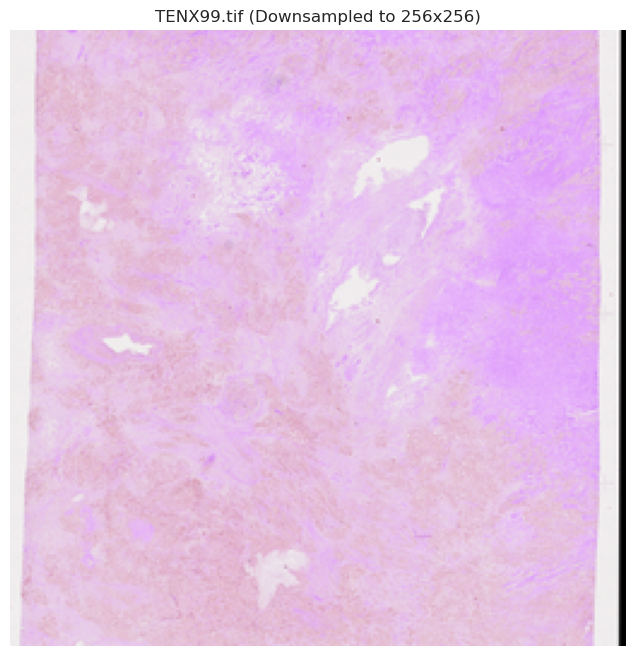

In [8]:
# Load /cwStorage/nodecw_group/jijh/hest_1k/wsis/TENX99.tif to visualize (downsample to 256px)
# Using pyvips instead of OpenCV for large WSI files

wsi_path = "/cwStorage/nodecw_group/jijh/hest_1k/wsis/TENX99.tif"

try:
    # Load the image using pyvips (handles large WSI files efficiently)
    image_vips = pyvips.Image.new_from_file(wsi_path)
    
    print(f"Original image size: {image_vips.width} x {image_vips.height}")
    
    # Create thumbnail with pyvips (much more efficient for large images)
    thumbnail_vips = image_vips.thumbnail_image(256, height=256, crop='centre')
    
    # Convert pyvips image to numpy array for matplotlib display
    img_np = np.ndarray(
        buffer=thumbnail_vips.write_to_memory(),
        dtype=np.uint8,
        shape=[thumbnail_vips.height, thumbnail_vips.width, thumbnail_vips.bands]
    )
    
    # Handle different color formats
    if img_np.shape[2] == 4:  # RGBA
        img_rgb = cv2.cvtColor(img_np, cv2.COLOR_BGRA2RGB)
    elif img_np.shape[2] == 3:  # BGR
        img_rgb = cv2.cvtColor(img_np, cv2.COLOR_BGR2RGB)
    else:  # Already RGB or other format
        img_rgb = img_np
    
    print(f"Thumbnail size: {img_rgb.shape[1]} x {img_rgb.shape[0]}")
    
    # Display the image
    plt.figure(figsize=(8, 8))
    plt.imshow(img_rgb)
    plt.title(f"TENX99.tif (Downsampled to {img_rgb.shape[1]}x{img_rgb.shape[0]})")
    plt.axis('off')
    plt.show()
    
except Exception as e:
    print(f"Error: Could not load image from {wsi_path}")
    print(f"Error details: {e}")


In [ ]:
import math
import io
import os
from PIL import Image
from IPython.display import display, HTML # 用于显示 HTML

# --- 1. 设置一个目录来保存输出的缩略图 ---
output_dir = "./qc_thumbnails"
os.makedirs(output_dir, exist_ok=True)
print(f"缩略图将保存在: {output_dir}")

image_paths_and_reasons = [] # 用于存储图片路径和原因

if 'samples_to_visualize' not in locals() or not samples_to_visualize:
    print("No samples were selected for visualization.")
else:
    path_dict = {s.sample_id: s.wsi_path for s in samples_to_analyze}
    THUMBNAIL_SIZE = 256

    print("\n--- 正在生成并保存每个低质量样本的缩略图 ---")
    
    for sample_id, reason in tqdm(samples_to_visualize.items(), desc="Generating Thumbnails"):
        wsi_path = path_dict.get(sample_id)
        output_path = os.path.join(output_dir, f"{sample_id}.jpg")
        
        if not wsi_path or not os.path.exists(wsi_path):
            print(f"Skipping {sample_id}: Path not found.")
            continue
            
        try:
            # 直接使用 pyvips 的 thumbnail 功能保存到文件，最高效！
            image_vips = pyvips.Image.new_from_file(wsi_path)
            image_vips.thumbnail_image(THUMBNAIL_SIZE, height=THUMBNAIL_SIZE, crop='centre').write_to_file(output_path)
            image_paths_and_reasons.append({'path': output_path, 'id': sample_id, 'reason': reason})
        except Exception as e:
            print(f"Error processing {sample_id}: {e}")

    # --- 2. 使用 HTML 创建一个灵活的图片画廊来显示 ---
    print("\n--- 生成图片画廊 ---")
    
    html_content = "<div>"
    for item in image_paths_and_reasons:
        # 使用 HTML 创建每个图片项，CSS 用于样式
        html_content += f"""
        <div style="display: inline-block; border: 1px solid #ddd; border-radius: 5px; padding: 10px; margin: 10px; text-align: center; vertical-align: top;">
            <img src="{item['path']}" alt="{item['id']}" style="max-width: {THUMBNAIL_SIZE}px; max-height: {THUMBNAIL_SIZE}px;">
            <p style="font-family: sans-serif; font-size: 12px; margin: 5px 0 0 0;">
                <strong>ID:</strong> {item['id']}<br>
                <span style="color: #d9534f;">{item['reason']}</span>
            </p>
        </div>
        """
    html_content += "</div>"
    
    # 在 Jupyter Notebook 中显示渲染后的 HTML
    display(HTML(html_content))

缩略图将保存在: ./qc_thumbnails

--- 正在生成并保存每个低质量样本的缩略图 ---


Generating Thumbnails:   0%|          | 0/12 [00:00<?, ?it/s]

## 有样本不规范，检查一下

In [10]:
import os
import sys
import pandas as pd
from tqdm import tqdm
import signal

# 确保可以导入您项目中的模块
# 如果 hest_reader.py 在不同目录，可能需要调整路径
# sys.path.append('/path/to/your/project') 

# 尝试导入 pyvips，如果失败则提供清晰的指引
try:
    import pyvips
except ImportError:
    print("错误: pyvips 库未找到。请确保它已正确安装。")
    sys.exit(1)

# --- 配置参数 ---
DATA_DIR = "/cwStorage/nodecw_group/jijh/hest_1k" # 您的数据目录
MAX_FILE_SIZE_GB = 10.0  # 文件大小上限 (GB)
MIN_PYRAMID_LEVELS = 3   # 标准 WSI 应有的最少金字塔层级数
TIMEOUT_SECONDS = 30     # 每个文件的处理超时时间 (秒)

# --- 超时处理机制 ---
class TimeoutException(Exception): pass

def timeout_handler(signum, frame):
    raise TimeoutException(f"Operation timed out after {TIMEOUT_SECONDS} seconds")

# --- 主检查函数 ---
def check_wsi_file(wsi_path: str) -> dict:
    """
    检查单个 WSI 文件的规范性，并返回一个包含诊断信息的结果字典。
    """
    result = {
        'path': wsi_path,
        'size_gb': -1.0,
        'pyramid_levels': -1,
        'status': 'Unknown',
        'details': ''
    }

    # 1. 检查文件是否存在
    if not os.path.exists(wsi_path):
        result['status'] = 'Error'
        result['details'] = 'File not found'
        return result

    # 2. 检查文件大小
    try:
        size_gb = os.path.getsize(wsi_path) / (1024**3)
        result['size_gb'] = round(size_gb, 3)
        if size_gb > MAX_FILE_SIZE_GB:
            result['status'] = 'Large File'
            result['details'] = f"Exceeds {MAX_FILE_SIZE_GB} GB limit. Likely a flat TIFF."
            # 对于超大文件，我们直接标记并跳过更耗时的金字塔检查
            return result
    except OSError as e:
        result['status'] = 'Error'
        result['details'] = f'Cannot get file size: {e}'
        return result

    # 3. 检查金字塔层级 (带有超时保护)
    signal.signal(signal.SIGALRM, timeout_handler)
    signal.alarm(TIMEOUT_SECONDS)
    
    try:
        # 使用 pyvips 打开文件并获取 n-pages (代表层级数)
        image = pyvips.Image.new_from_file(wsi_path)
        num_levels = image.get_n_pages()
        result['pyramid_levels'] = num_levels
        
        # 根据层级数判断状态
        if num_levels < MIN_PYRAMID_LEVELS:
            result['status'] = 'Flat TIFF'
            result['details'] = f"Only {num_levels} level(s) found. Standard WSI should have >= {MIN_PYRAMID_LEVELS}."
        else:
            result['status'] = 'OK'
            result['details'] = 'Standard pyramidal WSI format.'

    except TimeoutException as e:
        result['status'] = 'Timeout'
        result['details'] = f'Processing timed out. Likely a stuck NFS handle or corrupt file.'
    except pyvips.Error as e:
        result['status'] = 'Error'
        result['details'] = f'PyVips error: {e}'
    finally:
        signal.alarm(0) # 确保在操作完成或出错后取消闹钟

    return result


# --- 主程序 ---
if __name__ == "__main__":
    print("--- WSI Format Compliance Check ---")
    print(f"Data Directory: {DATA_DIR}")
    print(f"Criteria: File Size < {MAX_FILE_SIZE_GB} GB, Pyramid Levels >= {MIN_PYRAMID_LEVELS}")
    print("-" * 35)

    try:
        dataset = HESTDataset(data_dir=DATA_DIR)
        all_samples = dataset.get_samples()
        print(f"Found {len(all_samples)} samples to check.")
    except Exception as e:
        print(f"Error initializing HESTDataset: {e}")
        sys.exit(1)

    results_list = []
    
    # 使用 tqdm 创建一个进度条
    for sample in tqdm(all_samples, desc="Checking WSI files"):
        if sample.wsi_path:
            check_result = check_wsi_file(sample.wsi_path)
            check_result['sample_id'] = sample.sample_id # 添加样本ID以方便关联
            results_list.append(check_result)
        else:
            # 处理元数据中有记录但找不到 WSI 文件的情况
            results_list.append({
                'sample_id': sample.sample_id,
                'path': 'N/A', 'size_gb': -1, 'pyramid_levels': -1,
                'status': 'Error', 'details': 'WSI path not found in metadata'
            })

    # 将结果转换为 DataFrame 以便分析
    report_df = pd.DataFrame(results_list)

    print("\n--- Check Complete. Generating Report. ---\n")

    # 1. 打印状态摘要
    print("Status Summary:")
    print(report_df['status'].value_counts())
    print("-" * 35)

    # 2. 识别并列出所有不规范的文件
    problematic_df = report_df[report_df['status'] != 'OK']

    if problematic_df.empty:
        print("Congratulations! All WSI files meet the specified standards.")
    else:
        print(f"Found {len(problematic_df)} problematic files:")
        # 设置 pandas 显示选项，以完整显示路径
        pd.set_option('display.max_rows', None)
        pd.set_option('display.max_colwidth', None)
        
        # 只显示关键列
        print(problematic_df[['sample_id', 'status', 'details', 'size_gb', 'pyramid_levels', 'path']])

    # 3. 将完整报告保存到 CSV 文件
    output_csv = "wsi_compliance_report.csv"
    report_df.to_csv(output_csv, index=False)
    print(f"\nFull report saved to '{output_csv}'")

--- WSI Format Compliance Check ---
Data Directory: /cwStorage/nodecw_group/jijh/hest_1k
Criteria: File Size < 10.0 GB, Pyramid Levels >= 3
-----------------------------------
Found 1229 samples to check.


Checking WSI files: 100%|██████████| 1229/1229 [00:14<00:00, 86.58it/s] 



--- Check Complete. Generating Report. ---

Status Summary:
status
OK            1227
Large File       2
Name: count, dtype: int64
-----------------------------------
Found 2 problematic files:
    sample_id      status                                     details  \
153    TENX99  Large File  Exceeds 10.0 GB limit. Likely a flat TIFF.   
154    TENX98  Large File  Exceeds 10.0 GB limit. Likely a flat TIFF.   

     size_gb  pyramid_levels  \
153   10.975              -1   
154   14.028              -1   

                                                     path  
153  /cwStorage/nodecw_group/jijh/hest_1k/wsis/TENX99.tif  
154  /cwStorage/nodecw_group/jijh/hest_1k/wsis/TENX98.tif  

Full report saved to 'wsi_compliance_report.csv'


In [11]:
import os
import shutil
import pandas as pd
import logging
from datetime import datetime

# --- 配置 (Configuration) ---

# 1. 输入报告的路径
REPORT_CSV_PATH = "wsi_compliance_report.csv"

# 2. 隔离“坏”文件的目标目录
ERROR_FILES_DIR = "/cwStorage/nodecw_group/jijh/error_tif"

# 3. 存放“好”的替换文件的源目录 (重要!)
#    你需要把 TENX98 和 TENX99 的正确版本预先放到这个目录里。
#    如果现在还没有正确的版本，可以先留空，脚本会跳过替换步骤。
CORRECT_FILES_SOURCE_DIR = "/cwStorage/nodecw_group/jijh/correct_wsi_source" 

# 4. 日志文件设置
LOG_FILE_PATH = "wsi_correction_log.txt"

# --- 设置日志记录 (Setup Logging for Traceability) ---
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler(LOG_FILE_PATH), # 记录到文件
        logging.StreamHandler()             # 同时在控制台打印
    ]
)

def move_with_safety_checks(src_path, dest_path):
    """
    一个更安全的文件移动函数，包含存在性检查和覆盖保护。
    返回 True 表示成功，False 表示失败。
    """
    # 检查源文件是否存在
    if not os.path.exists(src_path):
        logging.error(f"Source file does not exist, cannot move: {src_path}")
        return False
    
    # 检查目标文件是否已存在，防止意外覆盖
    if os.path.exists(dest_path):
        logging.warning(f"Destination file already exists, skipping move to prevent overwrite: {dest_path}")
        return False
        
    try:
        shutil.move(src_path, dest_path)
        logging.info(f"Successfully moved: {src_path} -> {dest_path}")
        return True
    except Exception as e:
        logging.error(f"Failed to move {src_path} to {dest_path}. Error: {e}")
        return False

# --- 主程序 (Main Execution Logic) ---
def main():
    logging.info("--- Starting WSI File Correction and Isolation Process ---")
    
    # 确保目标目录存在
    os.makedirs(ERROR_FILES_DIR, exist_ok=True)
    os.makedirs(CORRECT_FILES_SOURCE_DIR, exist_ok=True) # 也确保源目录存在
    
    # 1. 读取合规性报告
    try:
        report_df = pd.read_csv(REPORT_CSV_PATH)
        logging.info(f"Successfully loaded report from '{REPORT_CSV_PATH}'.")
    except FileNotFoundError:
        logging.error(f"Fatal: Report file not found at '{REPORT_CSV_PATH}'. Aborting.")
        return

    # 2. 筛选出所有需要处理的“问题”文件
    problematic_files_df = report_df[report_df['status'] != 'OK'].copy()
    
    if problematic_files_df.empty:
        logging.info("No problematic files found in the report. Nothing to do. Exiting.")
        return
        
    logging.info(f"Found {len(problematic_files_df)} files to process.")

    # 3. 遍历并处理每个问题文件
    for index, row in problematic_files_df.iterrows():
        sample_id = row['sample_id']
        original_wsi_path = row['path']
        status = row['status']
        
        logging.info(f"--- Processing sample: {sample_id} (Status: {status}) ---")
        
        # --- 步骤 A: 隔离问题文件 ---
        # 构造目标路径
        file_name = os.path.basename(original_wsi_path)
        error_file_dest_path = os.path.join(ERROR_FILES_DIR, file_name)
        
        logging.info(f"Attempting to isolate problematic file '{file_name}'...")
        move_with_safety_checks(original_wsi_path, error_file_dest_path)
        
        # --- 步骤 B: 放置正确的替换文件 (如果存在) ---
        correct_file_source_path = os.path.join(CORRECT_FILES_SOURCE_DIR, file_name)
        
        if os.path.exists(correct_file_source_path):
            logging.info(f"Correct version found for '{file_name}'. Attempting to place it...")
            # 注意：这里的目标路径是原始文件的路径
            move_with_safety_checks(correct_file_source_path, original_wsi_path)
        else:
            logging.warning(f"No correct version found for '{file_name}' in '{CORRECT_FILES_SOURCE_DIR}'. The original location will be empty.")
            
    logging.info("--- WSI File Correction and Isolation Process Finished ---")


if __name__ == "__main__":
    main()

2025-06-19 00:37:05,622 - INFO - --- Starting WSI File Correction and Isolation Process ---
2025-06-19 00:37:05,639 - INFO - Successfully loaded report from 'wsi_compliance_report.csv'.
2025-06-19 00:37:05,641 - INFO - Found 2 files to process.
2025-06-19 00:37:05,643 - INFO - --- Processing sample: TENX99 (Status: Large File) ---
2025-06-19 00:37:05,644 - INFO - Attempting to isolate problematic file 'TENX99.tif'...
2025-06-19 00:37:05,685 - INFO - Successfully moved: /cwStorage/nodecw_group/jijh/hest_1k/wsis/TENX99.tif -> /cwStorage/nodecw_group/jijh/error_tif/TENX99.tif
2025-06-19 00:37:05,686 - WARNING - No correct version found for 'TENX99.tif' in '/cwStorage/nodecw_group/jijh/correct_wsi_source'. The original location will be empty.
2025-06-19 00:37:05,688 - INFO - --- Processing sample: TENX98 (Status: Large File) ---
2025-06-19 00:37:05,689 - INFO - Attempting to isolate problematic file 'TENX98.tif'...
2025-06-19 00:37:05,692 - INFO - Successfully moved: /cwStorage/nodecw_grou

In [12]:
import os
import sys
import glob
import logging
from datetime import datetime

try:
    import pyvips
except ImportError:
    print("错误: pyvips 库未找到。请确保它已正确安装。")
    sys.exit(1)

# --- 配置 (Configuration) ---

# 1. 存放“坏”文件的源目录
ERROR_FILES_DIR = "/cwStorage/nodecw_group/jijh/error_tif"

# 2. 存放转换后“好”文件的目标目录
PROCESSED_WSI_DIR = "/cwStorage/nodecw_group/jijh/processed_wsis"

# 3. 日志文件设置
LOG_FILE_PATH = "wsi_conversion_log.txt"

# 4. VIPS 转换参数 (这些是行业标准设置)
VIPS_OPTIONS = {
    "tile": True,            # 必须！启用瓦片化
    "pyramid": True,         # 必须！创建多分辨率金字塔
    "compression": "jpeg",   # 使用JPEG压缩，平衡质量和大小
    "Q": 90,                 # JPEG压缩质量 (75-95是常用范围)
    "tile_width": 256,       # 瓦片宽度 (像素)
    "tile_height": 256,      # 瓦片高度 (像素)
    "bigtiff": True,         # 允许输出文件超过4GB
}

# --- 设置日志记录 ---
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(process)d - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler(LOG_FILE_PATH),
        logging.StreamHandler()
    ]
)

# --- 主转换函数 ---
def convert_wsi(source_path: str, dest_path: str):
    """
    将单个扁平TIFF文件转换为带金字塔的标准WSI格式。
    """
    try:
        logging.info(f"开始转换: {os.path.basename(source_path)}")
        start_time = datetime.now()
        
        # 检查目标文件是否已存在，如果存在则跳过，避免重复工作
        if os.path.exists(dest_path):
            logging.warning(f"目标文件已存在，跳过转换: {dest_path}")
            return True

        # 使用pyvips加载源图像
        image = pyvips.Image.new_from_file(source_path, access="sequential")
        
        # 使用tiffsave函数和我们定义的参数来保存
        image.tiffsave(dest_path, **VIPS_OPTIONS)
        
        end_time = datetime.now()
        duration = end_time - start_time
        logging.info(f"转换成功！耗时: {duration}. 输出文件: {dest_path}")
        return True
        
    except pyvips.Error as e:
        logging.error(f"转换失败: {os.path.basename(source_path)}. PyVips Error: {e}")
        return False
    except Exception as e:
        logging.error(f"转换失败: {os.path.basename(source_path)}. Unexpected Error: {e}")
        return False


# --- 主程序 ---
def main():
    logging.info("--- WSI Conversion to Pyramidal TIFF ---")
    
    # 确保目标目录存在
    os.makedirs(PROCESSED_WSI_DIR, exist_ok=True)
    
    # 1. 查找所有在error目录中的.tif文件
    files_to_convert = glob.glob(os.path.join(ERROR_FILES_DIR, "*.tif"))
    
    if not files_to_convert:
        logging.info("在 'error_tif' 目录中没有找到 .tif 文件。无需转换。")
        return
        
    logging.info(f"找到 {len(files_to_convert)} 个文件需要转换。")
    
    successful_conversions = 0
    failed_conversions = 0

    # 2. 遍历并转换每个文件
    for source_file_path in files_to_convert:
        file_name = os.path.basename(source_file_path)
        dest_file_path = os.path.join(PROCESSED_WSI_DIR, file_name)
        
        if convert_wsi(source_file_path, dest_file_path):
            successful_conversions += 1
        else:
            failed_conversions += 1
            
    logging.info("--- 转换流程结束 ---")
    logging.info(f"成功转换: {successful_conversions} 个文件")
    logging.info(f"转换失败: {failed_conversions} 个文件")


if __name__ == "__main__":
    main()

2025-06-19 00:38:59,066 - INFO - --- WSI Conversion to Pyramidal TIFF ---
2025-06-19 00:38:59,073 - INFO - 找到 2 个文件需要转换。
2025-06-19 00:38:59,074 - INFO - 开始转换: TENX99.tif
2025-06-19 00:39:03,595 - INFO - VIPS: vips__open_image_write: opening with O_TMPFILE
2025-06-19 00:39:03,600 - INFO - VIPS: vips__open_image_write: O_TMPFILE failed!
2025-06-19 00:39:03,601 - INFO - VIPS: vips__open_image_write: simple open
2025-06-19 00:39:03,603 - INFO - VIPS: vips__open_image_write: opening with O_TMPFILE
2025-06-19 00:39:03,604 - INFO - VIPS: vips__open_image_write: O_TMPFILE failed!
2025-06-19 00:39:03,605 - INFO - VIPS: vips__open_image_write: simple open
2025-06-19 00:39:03,606 - INFO - VIPS: vips__open_image_write: opening with O_TMPFILE
2025-06-19 00:39:03,607 - INFO - VIPS: vips__open_image_write: O_TMPFILE failed!
2025-06-19 00:39:03,608 - INFO - VIPS: vips__open_image_write: simple open
2025-06-19 00:39:03,701 - INFO - VIPS: threadpool completed with 6 workers
2025-06-19 00:39:03,759 - IN

In [13]:
import os
import shutil
import glob
import logging
from datetime import datetime

# --- 配置 (Configuration) ---

# 1. 存放已转换好的“好”文件的源目录
PROCESSED_WSI_DIR = "/cwStorage/nodecw_group/jijh/processed_wsis"

# 2. WSI文件在数据集中的最终目标目录
FINAL_WSI_DIR = "/cwStorage/nodecw_group/jijh/hest_1k/wsis"

# 3. 日志文件设置
LOG_FILE_PATH = "wsi_placement_log.txt"

# --- 设置日志记录 (Setup Logging for Traceability) ---
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler(LOG_FILE_PATH),
        logging.StreamHandler()
    ]
)

def move_with_safety_checks(src_path, dest_path):
    """
    一个更安全的文件移动函数，包含存在性检查和覆盖保护。
    返回 True 表示成功，False 表示失败。
    """
    # 检查源文件是否存在
    if not os.path.exists(src_path):
        logging.error(f"Source file does not exist, cannot move: {src_path}")
        return False
    
    # 检查目标位置是否已存在同名文件，防止意外覆盖
    if os.path.exists(dest_path):
        logging.warning(f"Destination file already exists, skipping move to prevent overwrite: {dest_path}")
        # 在这种情况下，我们也可以认为操作“成功”了，因为它已经在了正确的位置
        return True
        
    try:
        shutil.move(src_path, dest_path)
        logging.info(f"Successfully placed: {src_path} -> {dest_path}")
        return True
    except Exception as e:
        logging.error(f"Failed to move {src_path} to {dest_path}. Error: {e}")
        return False

# --- 主程序 (Main Execution Logic) ---
def main():
    logging.info("--- Starting Final WSI Placement Process ---")
    
    # 确保源和目标目录都存在
    if not os.path.isdir(PROCESSED_WSI_DIR):
        logging.error(f"Source directory for processed files not found: '{PROCESSED_WSI_DIR}'. Aborting.")
        return
        
    if not os.path.isdir(FINAL_WSI_DIR):
        logging.error(f"Final destination directory not found: '{FINAL_WSI_DIR}'. Aborting.")
        return

    # 1. 查找所有在 processed_wsis 目录中的 .tif 文件
    files_to_move = glob.glob(os.path.join(PROCESSED_WSI_DIR, "*.tif"))
    
    if not files_to_move:
        logging.info("No processed .tif files found in the source directory. Nothing to do.")
        return
        
    logging.info(f"Found {len(files_to_move)} processed files to place in the final destination.")
    
    successful_moves = 0
    failed_moves = 0

    # 2. 遍历并移动每个文件
    for source_file_path in files_to_move:
        file_name = os.path.basename(source_file_path)
        # 构造最终的目标路径
        dest_file_path = os.path.join(FINAL_WSI_DIR, file_name)
        
        logging.info(f"--- Placing file: {file_name} ---")
        if move_with_safety_checks(source_file_path, dest_file_path):
            successful_moves += 1
        else:
            failed_moves += 1
            
    logging.info("--- Final Placement Process Finished ---")
    logging.info(f"Successfully placed: {successful_moves} files")
    logging.info(f"Failed to place: {failed_moves} files")
    logging.info(f"All processed files have been moved to: {FINAL_WSI_DIR}")


if __name__ == "__main__":
    main()

2025-06-19 00:55:43,892 - INFO - --- Starting Final WSI Placement Process ---
2025-06-19 00:55:43,896 - INFO - Found 2 processed files to place in the final destination.
2025-06-19 00:55:43,897 - INFO - --- Placing file: TENX99.tif ---
2025-06-19 00:55:43,900 - INFO - Successfully placed: /cwStorage/nodecw_group/jijh/processed_wsis/TENX99.tif -> /cwStorage/nodecw_group/jijh/hest_1k/wsis/TENX99.tif
2025-06-19 00:55:43,901 - INFO - --- Placing file: TENX98.tif ---
2025-06-19 00:55:43,904 - INFO - Successfully placed: /cwStorage/nodecw_group/jijh/processed_wsis/TENX98.tif -> /cwStorage/nodecw_group/jijh/hest_1k/wsis/TENX98.tif
2025-06-19 00:55:43,905 - INFO - --- Final Placement Process Finished ---
2025-06-19 00:55:43,906 - INFO - Successfully placed: 2 files
2025-06-19 00:55:43,906 - INFO - Failed to place: 0 files
2025-06-19 00:55:43,907 - INFO - All processed files have been moved to: /cwStorage/nodecw_group/jijh/hest_1k/wsis
